In this notebook we will try to cluster student performance on several test. Dataset used in this notebook can be accessed from [link]('https://www.kaggle.com/datasets/phuc16102001/vietnam-highschool-exam-2017-to-2021?select=2017-2021.csv').

This quick clustering run-through will use Gaussian Mixture Model and BIC and AIC score to evaluate the optimal cluster based on model persepective.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings(action='ignore')

## Data Loading

In [2]:
df = pd.read_csv('2017-2021.csv')
df = df[df['Year']==2021].sample(3000)
df.shape

(3000, 12)

In [3]:
df.head()

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
3751310,28007394,3.0,6.00,NaN,NaN,4.4,2021,NaN,4.00,6.25,6.25,28
4169037,61000460,5.0,6.25,NaN,NaN,3.8,2021,NaN,4.00,8.00,9.25,61
3900458,40004695,7.4,6.25,5.25,5.25,4.2,2021,6.25,NaN,NaN,NaN,40
3414575,2040755,8.2,7.75,NaN,NaN,8.4,2021,NaN,4.25,7.75,9.75,2
4156646,59004088,5.8,7.75,NaN,NaN,6.2,2021,NaN,3.75,7.25,7.50,59


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 3751310 to 4140937
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SBD        3000 non-null   int64  
 1   Toan       2972 non-null   float64
 2   Van        2949 non-null   float64
 3   Ly         1051 non-null   float64
 4   Sinh       1042 non-null   float64
 5   Ngoai ngu  2634 non-null   float64
 6   Year       3000 non-null   int64  
 7   Hoa        1059 non-null   float64
 8   Lich su    1924 non-null   float64
 9   Dia ly     1903 non-null   float64
 10  GDCD       1614 non-null   float64
 11  MaTinh     3000 non-null   int64  
dtypes: float64(9), int64(3)
memory usage: 304.7 KB


In [5]:
df.describe()

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
count,3.000000e+03,2972.000000,2949.000000,1051.000000,1042.000000,2634.000000,3000.0,1059.000000,1924.000000,1903.000000,1614.000000,3000.000000
mean,2.713477e+07,6.609758,6.473737,6.556851,5.535749,5.880790,2021.0,6.552644,4.975702,6.967945,8.412639,27.118667
std,1.988139e+07,1.687014,1.345417,1.402350,1.406971,2.203406,0.0,1.664819,1.764038,1.150748,1.130492,19.891752
min,1.000112e+06,1.000000,1.500000,1.500000,1.500000,1.400000,2021.0,1.500000,1.000000,2.250000,3.500000,1.000000
25%,5.004888e+06,5.600000,5.750000,5.500000,4.500000,4.000000,2021.0,5.500000,3.750000,6.250000,7.750000,5.000000
50%,2.601956e+07,7.000000,6.500000,6.750000,5.500000,5.600000,2021.0,7.000000,4.750000,7.000000,8.500000,26.000000
75%,4.500573e+07,8.000000,7.500000,7.750000,6.500000,7.800000,2021.0,7.750000,6.250000,7.750000,9.250000,45.000000
max,6.400676e+07,9.600000,9.500000,9.750000,9.750000,10.000000,2021.0,9.500000,10.000000,10.000000,10.000000,64.000000


In [6]:
df.head(2)

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
3751310,28007394,3.0,6.00,NaN,NaN,4.4,2021,NaN,4.0,6.25,6.25,28
4169037,61000460,5.0,6.25,NaN,NaN,3.8,2021,NaN,4.0,8.00,9.25,61


In [7]:
# select numerical only
num = ['Toan','Van','Ly','Sinh','Ngoai ngu',
       'Hoa','Lich su','Dia ly','GDCD']

dfc = df[num]

In [8]:
dfc.isnull().sum() / dfc.shape[0] * 100

Toan          0.933333
Van           1.700000
Ly           64.966667
Sinh         65.266667
Ngoai ngu    12.200000
Hoa          64.700000
Lich su      35.866667
Dia ly       36.566667
GDCD         46.200000
dtype: float64

In [9]:
# drop columns with high proportion of MV
dfc.drop(['Ly', 'Sinh', 'Hoa', 'GDCD'], axis=1, inplace=True)

In [10]:
# drop rows with MV
dfc.dropna(inplace=True)

In [11]:
dfc.isnull().sum() / dfc.shape[0] * 100

Toan         0.0
Van          0.0
Ngoai ngu    0.0
Lich su      0.0
Dia ly       0.0
dtype: float64

In [12]:
X = dfc.copy()

In [ ]:
clus_sample = dfc.index.tolist()

## EDA ANALYSIS

In [14]:
# cek korelasi antara setiap mapel
# dsb
dfc.shape

(1614, 5)

In [15]:
# check skewness
for i in dfc.columns:
    print(i, ': ', dfc[i].skew())

Toan :  -0.4500811974377402
Van :  -0.5800255691490883
Ngoai ngu :  0.4176875145291535
Lich su :  0.3433230505222388
Dia ly :  -0.18818993103752008


In [16]:
# check outlier
wins_gauss = Winsorizer(capping_method='gaussian', fold=3, tail='both')
dfc = wins_gauss.fit_transform(dfc)

In [17]:
# scaling
scaler = MinMaxScaler()
dfc = pd.DataFrame(scaler.fit_transform(dfc))
dfc.head()

,0,1,2,3,4
0,0.181677,0.498973,0.348837,0.333333,0.397922
1,0.445652,0.534761,0.279070,0.333333,0.678892
2,0.868012,0.749487,0.813953,0.361111,0.638753
3,0.551242,0.749487,0.558140,0.305556,0.558476
4,0.577640,0.570549,0.348837,0.500000,0.598615


In [18]:
# check VIF
# -----

In [19]:
# PCA
pca = PCA()
pca.fit(dfc)

np.cumsum(pca.explained_variance_ratio_)
# check elbow with visualization

array([0.58417601, 0.7623733 , 0.86197366, 0.94275587, 1.        ])

In [20]:
pca = PCA(n_components=.90)
dfc = pd.DataFrame(pca.fit_transform(dfc))
dfc


,0,1,2,3
0,0.387439,-0.027440,0.069854,0.266214
1,0.202003,0.126248,-0.051100,0.028518
2,-0.406620,-0.228908,-0.031859,-0.078604
3,-0.058114,-0.130901,-0.106618,0.117908
4,0.048028,0.132909,-0.025458,-0.016060
...,...,...,...,...
1609,0.527786,0.193095,-0.087022,-0.042933
1610,0.457115,0.160899,-0.123836,-0.018774
1611,-0.047260,-0.182735,-0.142067,-0.004292
1612,-0.463843,-0.006124,0.031597,-0.072757


<AxesSubplot:xlabel='0', ylabel='1'>

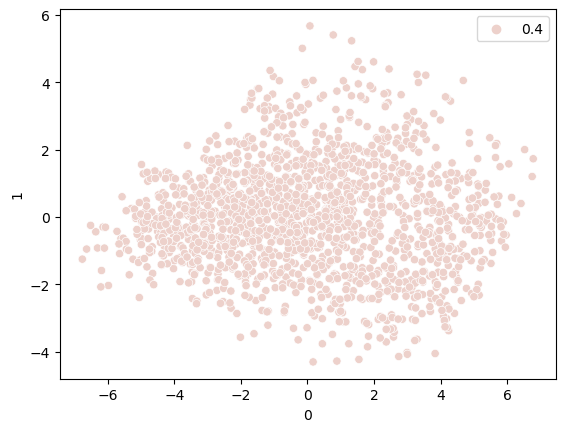

In [21]:
# for visualization
pca_viz = PCA(n_components=2)
X_viz = pd.DataFrame(pca_viz.fit_transform(X))
sns.scatterplot(X_viz[0], X_viz[1],hue=0.4)

## Preprocess

In [22]:
pipe = Pipeline([
    ('wins', Winsorizer(capping_method='gaussian', fold=3, tail='both')),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=.90))
])

In [23]:
X.head(3)

,Toan,Van,Ngoai ngu,Lich su,Dia ly
3751310,3.0,6.00,4.4,4.00,6.25
4169037,5.0,6.25,3.8,4.00,8.00
3414575,8.2,7.75,8.4,4.25,7.75


In [24]:
X_tr = pipe.fit_transform(X)
X_tr

array([[ 0.3874388 , -0.02743984,  0.06985391,  0.26621371],
       [ 0.20200338,  0.12624814, -0.0511003 ,  0.02851758],
       [-0.4066204 , -0.22890771, -0.03185875, -0.07860413],
       ...,
       [-0.04725978, -0.18273537, -0.14206658, -0.00429222],
       [-0.46384292, -0.00612391,  0.03159703, -0.07275672],
       [ 0.28044071, -0.00163597, -0.1400827 ,  0.07857912]])

In [25]:
np.allclose(X_tr, dfc)

True

## Modeling

In [26]:
# Get Best Cluster and Best Hyperparameter
# You can think this below code is like GridSearchCV on Supervised Learning
min_aic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        aic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X_tr).aic(X_tr)
        if aic < min_aic:
            min_aic = aic
            best_k = k
            best_covariance_type = covariance_type

print('Best - n_components    : ', best_k)
print('Best - covariance_type : ', best_covariance_type)

Best - n_components    :  8
Best - covariance_type :  full


In [27]:
models = [GaussianMixture(n_components=k) for k in range(2,6)]
aic = [model.fit(X_tr).aic(X_tr) for model in models]

for k, skor in zip(range(2,6), aic):
    print(k, ': ', skor)

2 :  -3589.2809184993116
3 :  -3838.865439776235
4 :  -3866.996849531336
5 :  -3895.1819904245926


In [28]:
k_5 = GaussianMixture(n_components=5)
labelz = k_5.fit_predict(X_tr)
labelz

array([2, 1, 4, ..., 0, 4, 1])

<AxesSubplot:xlabel='0', ylabel='1'>

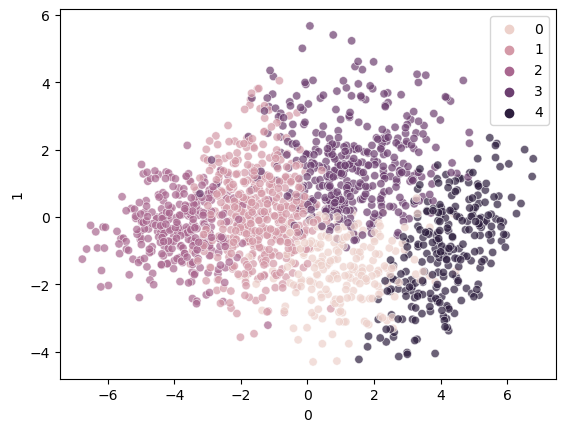

In [29]:
sns.scatterplot(X_viz[0], X_viz[1], hue=labelz, alpha=.7)

## EDA CLuster

In [33]:
df_eda = df.loc[clus_sample].copy()
df_eda

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
3751310,28007394,3.0,6.00,NaN,NaN,4.4,2021,NaN,4.00,6.25,6.25,28
4169037,61000460,5.0,6.25,NaN,NaN,3.8,2021,NaN,4.00,8.00,9.25,61
3414575,2040755,8.2,7.75,NaN,NaN,8.4,2021,NaN,4.25,7.75,9.75,2
4156646,59004088,5.8,7.75,NaN,NaN,6.2,2021,NaN,3.75,7.25,7.50,59
3734205,27001391,6.0,6.50,NaN,NaN,4.4,2021,NaN,5.50,7.50,9.00,27
...,...,...,...,...,...,...,...,...,...,...,...,...
3645350,21010175,4.4,5.25,NaN,NaN,1.4,2021,NaN,3.50,7.25,8.50,21
4026697,49001472,4.6,5.75,NaN,NaN,1.8,2021,NaN,3.50,7.25,8.75,49
3790451,30006313,6.6,7.50,NaN,NaN,6.0,2021,NaN,3.00,7.25,7.25,30
3389019,2014798,8.0,7.50,NaN,NaN,8.0,2021,NaN,5.75,8.75,9.75,2


In [34]:
df_eda['cluster'] = labelz
df_eda

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh,cluster
3751310,28007394,3.0,6.00,NaN,NaN,4.4,2021,NaN,4.00,6.25,6.25,28,2
4169037,61000460,5.0,6.25,NaN,NaN,3.8,2021,NaN,4.00,8.00,9.25,61,1
3414575,2040755,8.2,7.75,NaN,NaN,8.4,2021,NaN,4.25,7.75,9.75,2,4
4156646,59004088,5.8,7.75,NaN,NaN,6.2,2021,NaN,3.75,7.25,7.50,59,0
3734205,27001391,6.0,6.50,NaN,NaN,4.4,2021,NaN,5.50,7.50,9.00,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645350,21010175,4.4,5.25,NaN,NaN,1.4,2021,NaN,3.50,7.25,8.50,21,2
4026697,49001472,4.6,5.75,NaN,NaN,1.8,2021,NaN,3.50,7.25,8.75,49,2
3790451,30006313,6.6,7.50,NaN,NaN,6.0,2021,NaN,3.00,7.25,7.25,30,0
3389019,2014798,8.0,7.50,NaN,NaN,8.0,2021,NaN,5.75,8.75,9.75,2,4


In [36]:
df_eda.groupby('cluster').mean()

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
cluster,,,,,,,,,,,,
0,2.168894e+07,6.517757,6.824766,NaN,NaN,7.123364,2021.0,NaN,4.478972,6.679907,8.353774,21.668224
1,3.098749e+07,5.749011,6.603121,NaN,NaN,4.018022,2021.0,NaN,4.374176,6.820330,8.290749,30.973626
2,3.035169e+07,4.263514,4.823649,NaN,NaN,3.287162,2021.0,NaN,3.396115,5.965372,7.274576,30.341216
3,3.019269e+07,6.800000,6.973190,NaN,NaN,5.384810,2021.0,NaN,6.770886,7.995570,9.053934,30.179747
4,2.017908e+07,7.870079,8.008189,NaN,NaN,8.856693,2021.0,NaN,6.141732,7.677165,9.023810,20.161417
